In [1]:
import sys
sys.path.append('src')
import numpy as np
from scipy.special import erf, erfinv
from scipy.sparse import issparse
from matplotlib import colormaps
import matplotlib.pyplot as plt
from models import *
from utils import *
from train_funcs import *
from visualization import *
rng = np.random.default_rng()

## Model Training

In [2]:
NE, NI, N_syl, N_HVC_per_syl = 600, 150, 3, 3
N_HVC = N_syl * N_HVC_per_syl

In [3]:
peak_rate, kernel_width = 150, 20

In [4]:
T_rend = 600 # Each rendition
N_rend = 25 # Number of renditions
T_burn = 500 # Burning
T = T_burn + N_rend * T_rend # Total

In [179]:
# Syllables and time stamps
N_shared_channels = 1
syl_cov = block_sym_mat(NE, K=N_shared_channels, var=3**2, cov=1.8**2)
# plt.imshow(syl_cov)
syl = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_syl)
print(syl.shape)
tsyl_start, tsyl_end, burst_ts = generate_syl_time(T, T_burn, T_rend, N_syl, N_HVC)
save_W_ts = np.round(tsyl_end[-1]).astype(int)

(3, 600)


In [180]:
_ = rng.standard_normal((N_HVC, N_rend)) # Little fluctuation
rH = generate_HVC(T, burst_ts, peak_rate+_, kernel_width+_)

In [181]:
# (T, NE)
aud = generate_discrete_aud(T, NE, tsyl_start, tsyl_end, syl)
# aud[:T_burn] = rng.normal(0, 1, size=(T_burn, NE))

In [182]:
gen = lognormal_gen
# gen = const_gen
c = 0.3
JEE0, JEI0, JIE0, JII0 = np.array([1, 1.7, 1.2, 1.7]) / 4
sEE, sEI, sIE, sII = np.array([JEE0, JEI0, JIE0, JII0]) * 0.1
JEE = generate_matrix(NE, NE, gen, c, rng=rng, mean=JEE0, std=sEE, sparse=c<=0.5) / np.sqrt(NE)
JEI = generate_matrix(NE, NI, gen, c, rng=rng, mean=JEI0, std=sEI, sparse=c<=0.5) / np.sqrt(NI)
JIE = generate_matrix(NI, NE, gen, c, rng=rng, mean=JIE0, std=sIE, sparse=c<=0.5) / np.sqrt(NE)
JII = generate_matrix(NI, NI, gen, c, rng=rng, mean=JII0, std=sII, sparse=c<=0.5) / np.sqrt(NI)

In [183]:
rEmax, rImax, thE, thI, sE, sI = 50, 100, 0, 0, 2, 2
phiE = lambda x: rEmax/2 * (1 + erf((x - thE) / (np.sqrt(2) * sE)))
phiI = lambda x: rImax/2 * (1 + erf((x - thI) / (np.sqrt(2) * sI)))

In [184]:
r_rest = 2 # target rate when phi(0)
rmax, s = 50, 2
th = -erfinv(r_rest * 2 / rmax - 1) * (np.sqrt(2) * s)
phi = lambda x: rmax/2 * (1 + erf((x - th) / (np.sqrt(2) * s)))

In [185]:
w0_mean_HVC2E, w0_std_HVC2E = 1/N_HVC, 1e-2
w0_mean_E2E, w0_std_E2E, cW_E2E = 1/N_HVC, 0, 0.05
w_inh_HVC2E = w0_mean_HVC2E
w_inh_E2E = w0_mean_E2E*cW_E2E
tauE, tauI, dt = 30, 10, 1

In [186]:
netFF = WCNet(NE, N_HVC, w0_mean_HVC2E, phi, tauE, 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEI = EINet(NE, NI, N_HVC, w0_mean_HVC2E, phiE, phiI, tauE, tauI, 
              JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
              w_inh=w_inh_HVC2E, w0_std=w0_std_HVC2E)
netEIrec = EINet(NE, NI, N_HVC, w0_mean_E2E, phiE, phiI, tauE, tauI, 
                 JEE=JEE.copy(), JEI=JEI.copy(), JIE=JIE.copy(), JII=JII.copy(), 
                 w_inh=w_inh_E2E, w0_std=w0_std_E2E, cW=cW_E2E)

Not a recurrent model and rI will not be calculated.


100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 5077.26it/s]


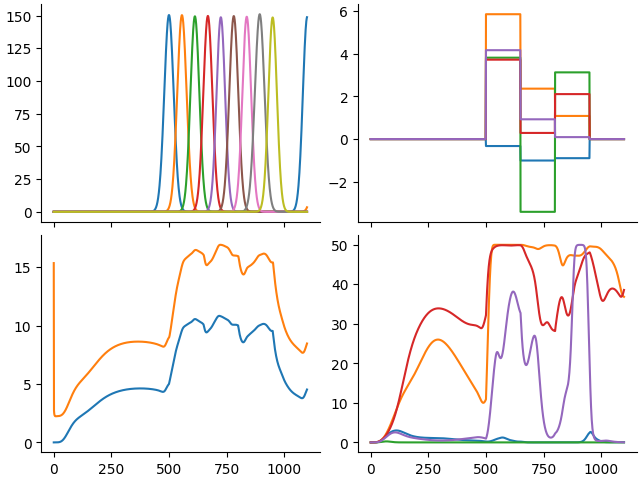

In [187]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
_ = netEIrec.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend,::1], [], T_burn+T_rend, dt, 0)
rE_pre = _[0]
fig, ax = plt.subplots(2, 2, sharex='all')
ax[0,0].plot(rH[:T_burn+T_rend])
ax[0,1].plot(aud[:T_burn+T_rend,:5])
ax[1,1].plot(rE_pre[:T_burn+T_rend,:5]);
ax[1,0].plot(rE_pre[:T_burn+T_rend,:].mean(axis=1));
ax[1,0].plot(_[1].mean(axis=1))

In [188]:
@njit(void(f8[:], f8[:], f8[:], i4[:], i4[:]))
def _outer(out, post, pre, indptr, indices):
    for i in range(len(pre)):
        # range in .data for the i-th col
        p, q = indptr[i], indptr[i+1] 
        out[p:q] = post[indices[p:q]] * pre[i]
        
def bilin_hebb_IE(net, t, rE, rI, lr, JIE0_mean, tauW, asyn_E, rE_th, **kwargs):
    ## lr < 0, anti-Hebbian
    rI_post, rE_pre = rI[t], rE[max(t-asyn_E,0)]
    if issparse(net.JIE):
        aux = np.zeros(net.JIE.data.shape)
        _outer(aux, rI_post - 10, rE_pre - rE_th, net.JIE.indptr, net.JIE.indices)
        dW = lr * aux - (net.JIE.data - JIE0_mean)
        net.JIE.data = np.clip(net.JIE.data + dW / tauW, a_min=1e-10, a_max=None)
    else:
        aux = (rI_post[:,None] - 10) * (rE_pre[None,:] - rE_th)
        dW = lr * aux - (net.JIE - JIE0_mean)
        net.JIE = np.clip(net.JIE + dW / tauW, a_min=1e-10, a_max=None)

In [198]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
# plasticity_kwargs = dict(plasticity=bilin_hebb_E_HVC, lr=-5e-2, 
#                          tauW=1e5, asyn_H=0, rE_th=1.5, hI0=0)
# _ = netFF.sim(hE0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
# WsFF = _[2]
# plasticity_kwargs = dict(plasticity=dict(HVC=bilin_hebb_E_HVC), lr=dict(HVC=-8e-2), 
#                          tauW=1e5, asyn_H=0, rE_th=1.5)
# _ = netEI.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
# WsEI = _[2]
# plasticity_kwargs = dict(plasticity=dict(JEE=bilin_hebb_EE), lr=dict(JEE=-2e-1), 
#                          tauW=1e5, JEE0_mean=JEE0/np.sqrt(NE), asyn_E=10, rE_th=1)
plasticity_kwargs = dict(plasticity=dict(JEI=bilin_hebb_EI,JIE=bilin_hebb_IE), 
                         lr=dict(JEI=2e-1,JIE=2e-1), tauW=1e5, 
                         JEI0_mean=JEI0/np.sqrt(NI), JIE0_mean=JIE0/np.sqrt(NE), 
                         asyn_E=10, asyn_I=0, rE_th=1, rI_th=15)
_ = netEIrec.sim(hE0, hI0, rH, aud, save_W_ts, T, dt, 1, **plasticity_kwargs)
WsEIrec = _[2]

100%|███████████████████████████████████| 15499/15499 [00:07<00:00, 2198.96it/s]


KeyError: 'JEE'

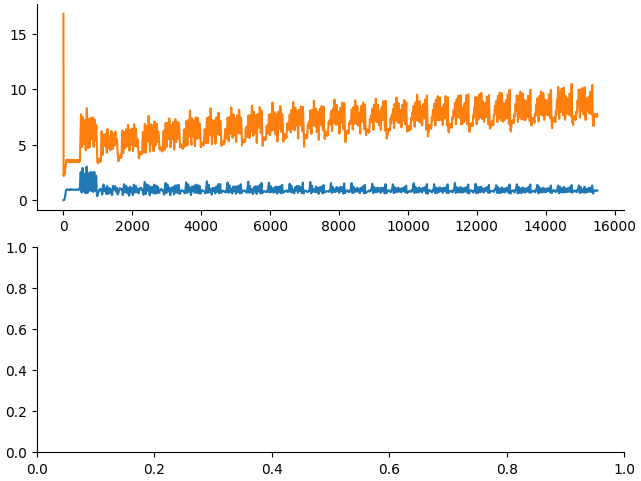

In [199]:
fig, ax = plt.subplots(2)
ax[0].plot(_[0].mean(axis=1))
ax[0].plot(_[1].mean(axis=1))
ax[1].plot([_.data.mean() for _ in WsEIrec['JEE']])
# ax[1].plot([_.data.mean() for _ in WsEIrec['JEI']])
# ax[1].plot([_.data.mean() for _ in WsEIrec['JIE']])
# ax[1].axhline(JEI0/np.sqrt(NI), c='C0', ls=':')
# ax[1].axhline(JIE0/np.sqrt(NE), c='C1', ls=':')

In [200]:
def plot_corr_mat(Ws, sortby=None, vmin=-1, vmax=1):
    corrs = [correlation(Ws[i].T, syl, dim=2) for i in (0,-1)]
    if sortby == 'min':
        idx = np.argsort(np.nanargmin(corrs[1], axis=1))
    elif sortby == 'max':
        idx = np.argsort(np.nanargmax(corrs[1], axis=1))
    fig, ax = plt.subplots(1, 2, sharey='all', figsize=(6, 2))
    for i, j in enumerate(corrs):
        im = j if sortby is None else j[idx,:]
        im = ax[i].imshow(im, aspect='auto', interpolation='none', 
                          vmin=vmin, vmax=vmax, cmap='seismic')
    ax[0].set_title('Before learning, corr. with\ncorrect song')
    ax[1].set_title('After learning, corr. with\ncorrect song')
    cax = fig.colorbar(im, ax=ax, label='Correlation', ticks=[vmin, 0, vmax])
    return fig, ax

In [201]:
fig, ax = plot_corr_mat([_.toarray() for _ in WsEIrec['JEE']], sortby='max', vmin=-0.5, vmax=0.5)
ax[0].set(ylabel='presyn. neuron index', xlabel='Time (ms)')

KeyError: 'JEE'

100%|█████████████████████████████████████| 1099/1099 [00:00<00:00, 5348.46it/s]


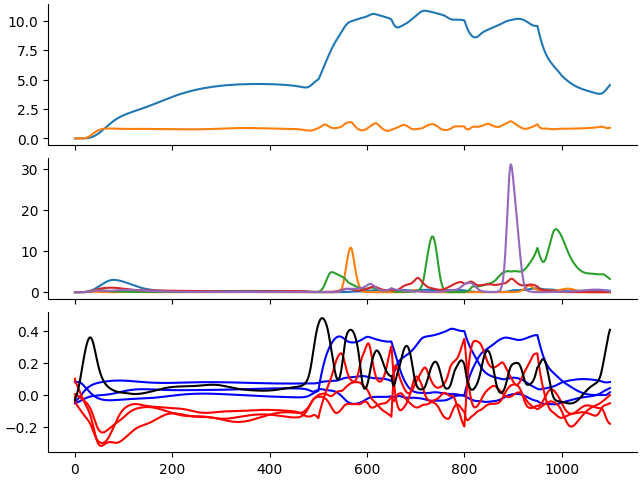

In [202]:
hE0 = rng.normal(loc=-10, scale=0.5, size=NE)
hI0 = rng.normal(loc=-1, scale=0.5, size=NI)
_ = netEIrec.sim(hE0, hI0, rH[:T_burn+T_rend], aud[:T_burn+T_rend,::1], [], T_burn+T_rend, dt, 0)
rE_post = _[0]
fig, ax = plt.subplots(3, sharex='all')
ax[0].plot(rE_pre[:T_burn+T_rend,:].mean(axis=1));
ax[0].plot(rE_post[:T_burn+T_rend,:].mean(axis=1));
# ax[1].plot(rE_pre[:T_burn+T_rend,:5]);
ax[1].plot(rE_post[:T_burn+T_rend,:5])
c_pre = correlation(rE_pre[:,:NE], syl, dim=2, cosine=False)
c_post = correlation(rE_post[:,:NE], syl, dim=2, cosine=False)
c = correlation(rE_pre[:,:NE], rE_post[:,:NE], dim=1, cosine=False)
ax[2].plot(c_pre, c='b')
ax[2].plot(c_post, c='r')
ax[2].plot(c, c='k')

In [203]:
from scipy.linalg import svd
J = np.block([[JEE.toarray(), -JEI.toarray()*2], 
              [JIE.toarray(), -JII.toarray()*2]])
svd_EI = svd(J)

J = np.block([[netEIrec.JEE.toarray(), -netEIrec.JEI.toarray()*2], 
              [netEIrec.JIE.toarray(), -netEIrec.JII.toarray()*2]])
svd_EIrec = svd(J)

[Text(0.5, 0, 'Index'), Text(0, 0.5, 'Correlation with TS patterns')]

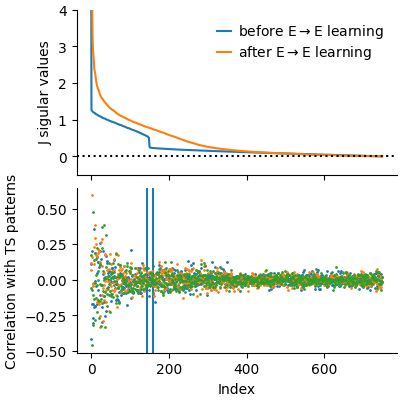

In [204]:
fig, ax = plt.subplots(2, figsize=(4,4), sharex='all')
ax[0].plot(svd_EI[1], label='before E$\\to$E learning')
ax[0].plot(svd_EIrec[1], label='after E$\\to$E learning')
ax[0].axhline(0, ls=':', c='k')
ax[1].axvline(145)
ax[1].axvline(160)
ax[0].set(ylabel='J sigular values', ylim=[-0.5, 4])
ax[0].legend()
c = correlation(svd_EIrec[0][:NE,:].T, syl, dim=2)
ax[1].plot(c, '.', ms=2)
ax[1].set(xlabel='Index', ylabel='Correlation with TS patterns')
# fig.savefig('svg/supplementary/svd_J.svg')

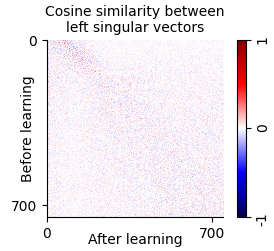

In [205]:
fig, ax = plt.subplots(1, figsize=(3, 2.5))
im = ax.imshow(svd_EI[0].T @ svd_EIrec[0], vmin=-1, vmax=1, 
               interpolation='none', cmap='seismic', aspect=1)
ax.set(xticks=[0,700], yticks=[0,700],
       title='Cosine similarity between\nleft singular vectors')
ax.set_xlabel('\nAfter learning', va='bottom')
ax.set_ylabel('\nBefore learning', va='top')
cax = fig.colorbar(im, ax=ax, fraction=0.04)
cax.set_ticks([-1,0,1], labels=[-1,0,1], rotation=90)
# fig.savefig('svg/left_sv_similarity.svg')

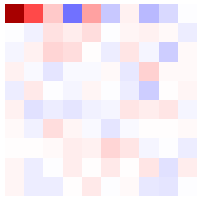

In [206]:
fig, ax = plt.subplots(1, figsize=(2,2))
i = 10
ax.imshow(svd_EI[0][:,:i].T @ svd_EIrec[0][:,:i], vmin=-1, vmax=1, 
          interpolation='none', cmap='seismic', aspect=1)
ax.set_axis_off()
# fig.savefig('svg/left_sv_similarity_zoomin.png')

## Test Model with Different Scenarios

In [123]:
Experiment.AUD_LIST

('correct', 'shuf_syl_idx', 'perturb', 'off')

In [124]:
N_repeat = 5
expFF = Experiment(netFF, rH, syl, noise=1, T_test=T_burn+T_rend, 
                   t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
expEI = Experiment(netEI, rH, syl, noise=1, T_test=T_burn+T_rend, 
                   t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
expEIrec = Experiment(netEIrec, rH, syl, noise=1, T_test=T_burn+T_rend, 
                   t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])

pert = rng.multivariate_normal(np.ones(NE), syl_cov, size=N_repeat)
pert_args = []
for i in range(N_repeat):
    _ = syl.copy()
    _[1] = pert[i]
    pert_args.extend([None, (_, 0), None, None])
test_codes = ['correct', 'perturb', 'off', 'correct'] # last one for playback
if_sing = [True, True, True, False]
test_names = ['Singing\ncorrect', 'Singing\nperturb',
              'Singing\ndeafen', 'Playback\n']
args = (test_codes * N_repeat, if_sing * N_repeat, pert_args)
FF_tests_all = expFF.sim_multi(*args)
EI_tests_all = expEI.sim_multi(*args)
EIrec_tests_all = expEIrec.sim_multi(*args)

100%|███████████████████████████████████████████| 20/20 [00:04<00:00,  4.89it/s]


In [125]:
def parse_trial(r):
    ret = np.zeros((N_repeat, T_rend, r.shape[-1]))
    for i in range(N_repeat):
        ret[i] = r[T_burn+i*T_rend:T_burn+(i+1)*T_rend]
    return ret

In [126]:
# res = EIrec_tests_all['rE']
# z_ctrl = parse_trial(res[0])
# z_pert = parse_trial(res[1])
# z = np.concat((z_ctrl, z_pert), axis=1)
# z_burn = np.concat((res[0][:T_burn], res[1][:T_burn]), axis=0)
# m, s = z.mean(axis=(0,1))/2+z_burn.mean(axis=0)/2, np.sqrt(z.var(axis=(0,1))/2+z_burn.var(axis=0)/2)
# plt.plot(z_ctrl[0,:,:5], c='r')
# plt.plot((z_ctrl[0,:,:5] - m[5]) / s[5], c='k')
# plt.plot(res[0][:,:10])

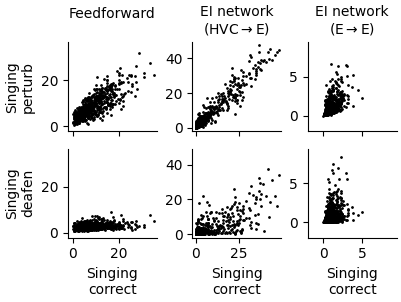

In [127]:
ti, tj = int(tsyl_start[0,0]), int(tsyl_end[2,0])
# ti, tj = int(tsyl_start[0,0])+100, int(tsyl_end[2,0])+100
fig, ax = plt.subplots(2, 3, sharex='col', sharey='col', figsize=(4, 3))
for i, res in enumerate((FF_tests_all['rE'], EI_tests_all['rE'], EIrec_tests_all['rE'])):
    z_ctrl = np.stack(res[::4])[:,ti:tj].mean(axis=(0,1))
    for j, k in enumerate(('pert', 'deaf')):
        z_pert = np.stack(res[j+1::4])[:,ti:tj].mean(axis=(0,1))
        ax[j,i].plot(z_ctrl, z_pert, 'o', ms=1, c='k')
        _ = max(z_ctrl.max(), z_pert.max()) + 1
        ax[j,i].set(aspect=1, xlim=[-2,_], ylim=[-2,_])
        # ax[j,i].plot([-3,6], [-3,6], c='r', ls='--')
        # ax[j,i].set(aspect=1)#, xlim=[-3,6], ylim=[-3,6])
        ax[-1,i].set(xlabel='Singing\ncorrect')
ax[0,0].set_ylabel('Singing\nperturb')
ax[1,0].set_ylabel('Singing\ndeafen')
ax[0,0].set_title('Feedforward\n', fontsize=10)
ax[0,1].set_title('EI network\n(HVC$\\to$E)', fontsize=10)
ax[0,2].set_title('EI network\n(E$\\to$E)', fontsize=10)
fig.savefig('svg/supplementary/learn_toy_joint_dist.svg')

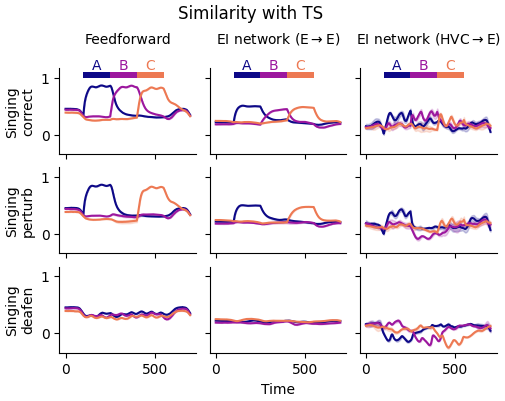

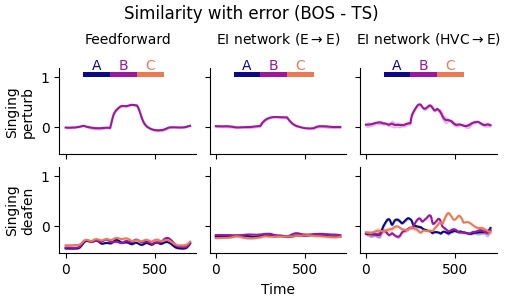

In [128]:
cmap = plt.get_cmap('plasma')

fig1, ax1 = plt.subplots(3, 3, sharex='all', sharey='all', figsize=(5,4))
fig2, ax2 = plt.subplots(2, 3, sharex='all', sharey='all', figsize=(5,3))

fig1.suptitle('Similarity with TS')
fig2.suptitle('Similarity with error (BOS - TS)')

ti, tj = int(tsyl_start[0,0])-100, T_burn+T_rend

for i, tests_all in enumerate((FF_tests_all, EI_tests_all, EIrec_tests_all)):
    for j, l in enumerate(test_names[:-1]):
        for k in range(3): # 3 syllables
            aux = np.stack(tests_all['rE'][j::4],0)[:,ti:tj]
            _ = correlation(aux, syl[k], dim=2, cosine=True)
            plot_mean_std(ax1[j,i], _.mean(axis=0), _.std(axis=0), 
                          a_fill=0.2, c=cmap(k/3))
            if j > 0:
                # (trial, NE)
                err = np.stack(tests_all['bos'][j::4],0)[:,k] - syl[None,k,:]
                if (err == 0).all():
                    continue
                _ = correlation(aux, err[:,None,:], dim=1, cosine=True)
                plot_mean_std(ax2[j-1,i], _.mean(axis=0), _.std(axis=0), 
                              a_fill=0.2, c=cmap(k/3))
                ax2[j-1,0].set_ylabel(l)
        ax1[j,0].set_ylabel(l)
    _  = '(HVC$\\to$E)\n' if i == 2 else '(E$\\to$E)\n'
    ax1[0,i].set_title('Feedforward\n' if i == 0 else 'EI network ' + _)
    ax2[0,i].set_title('Feedforward\n' if i == 0 else 'EI network ' + _)
    
#### Plot syl indicators ####
ts = [(tsyl_start[i,0]-T_burn+100, tsyl_end[i,0]-T_burn+100) for i in range(N_syl)]
for k in range(3):
    y0, y1 = 1, 0.1
    for i, (t0, t1) in enumerate(ts):
        ax1[0,k].add_patch(plt.Rectangle((t0, y0), t1-t0, y1, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
        ax1[0,k].text((t1+t0)/2, y0+y1, chr(65+i), color=cmap(i/N_syl), 
                      ha='center', va='bottom')
        
        ax2[0,k].add_patch(plt.Rectangle((t0, y0), t1-t0, y1, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
        ax2[0,k].text((t1+t0)/2, y0+y1, chr(65+i), color=cmap(i/N_syl), 
                      ha='center', va='bottom')

ax1[-1,1].set_xlabel('Time')
ax2[-1,1].set_xlabel('Time')

fig1.savefig('svg/supplementary/similarity_TS.svg')
fig2.savefig('svg/supplementary/similarity_err.svg')

554 46
397 203
102 48


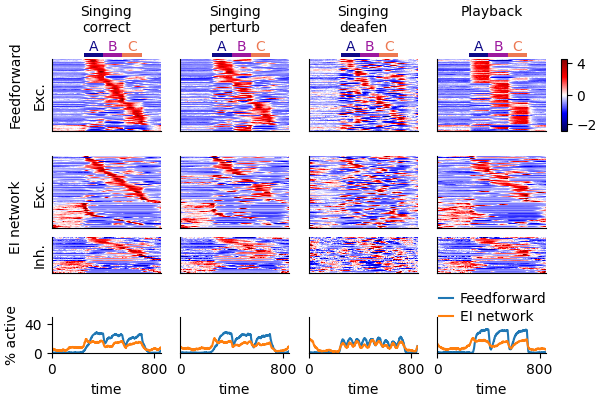

In [129]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
pop = ('Exc.', 'Exc.', 'Inh.')
N_tests = len(test_names)
wr = [1]*N_tests+[0.05]
fig, ax = plt.subplots(5, len(wr), 
                       figsize=(6, 4), 
                       width_ratios=wr, 
                       height_ratios=[1, 0.1, 1, 0.5, 0.5])
im_idx, ln_idx, white_space_idx = [0, 2, 3], [4], [1]

for i in range(ax.shape[1]):
    for j in white_space_idx:
        ax[j,i].set_axis_off()
ax[-1,-1].set_axis_off()

#### Plot rate heatmaps ####
for i, p in zip(im_idx, pop):
    zs = []
    tests = FF_tests_all if i == 0 else EI_tests_all
    for k, l in enumerate(tests['r'+p[0]][:4]):
        zs.append(normalize(l[ti:tj], axis=0))

    zmin = max(min(list(map(lambda _: _[0].min(), zs))), -2.5)
    zmax = min(max(list(map(lambda _: _[0].max(), zs))), 4.5)
    idx = temporal_sort(zs[0], 'dmean', t0=T_burn-ti)[1]

    norm = TwoSlopeNorm(0, -2.5, 4.5)
    
    for k, (z, l) in enumerate(zip(zs, test_names)):
        # Uncomment the below to sort case-by-case
        im = ax[i,k].imshow(z[:,idx].T, aspect='auto', cmap='seismic', 
                            interpolation='none', norm=norm, rasterized=True)
        if i == 0:
            cbar = fig.colorbar(im, cax=ax[i,N_tests])
            # cbar.set_ticks([np.ceil(zmin), 0, np.floor(zmax)-1])
            cbar.set_ticks([-2, 0, 4])
        else:
            ax[i,N_tests].set_axis_off()
        # ax[i,k].axvline(T_burn-ti, ls='--', c='k', lw=2)
        ax[i,k].set(xticks=[], yticks=[])
        ax[0,k].set_title(l+'\n', fontsize=10, va='bottom')
        ax[-1,k].set(xlabel='time', xticks=[0, 800])
    N = zs[0].shape[1]
    ax[i,0].set(ylabel='\n'+p, yticks=[])#, yticks=[N//2, N])
fig.text(0.025, 0.9, 'Feedforward', rotation=90, ha='center', va='top')
fig.text(0.025, 0.55, 'EI network', rotation=90, ha='center', va='top')

#### Plot histograms for the heatmaps ####
ls = []
for i in ln_idx:
    # calculate peak times and active durations
    for rE, c in zip((FF_tests_all['rE'], EI_tests_all['rE']), ('C0', 'C1')):
        for k, z in enumerate(rE[:4]):
            peaks = (normalize(z[ti:tj], axis=0) > 1.5).mean(axis=1) * 100
        
            l, = ax[i,k].plot(peaks, color=c, 
                              label='Feedforward' if c=='C0' else 'EI network')
            if k == 0: # for legend
                ls.append(l)
            # ax[i,k].axvline(T_burn-ti, ls='--', c='k', lw=2)
            ax[i,k].set(xlim=[0,len(peaks)], yticks=[], ylim=[0, 50])
        ax[i,0].set(yticks=[0, 40], ylabel='% active', title='\n')
fig.legend(handles=ls, loc=(0.72, 0.18))

#### Plot syl indicators ####
cmap = plt.get_cmap('plasma')
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
for k in range(4):
    y0, y1 = -20, -N/5
    for i, (t0, t1) in enumerate(ts):
        ax[0,k].add_patch(plt.Rectangle((t0, y0), t1-t0, y1, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
        ax[0,k].text((t1+t0)/2, y0+y1, chr(65+i), color=cmap(i/N_syl), 
                     ha='center', va='bottom')
fig.savefig('svg/compare_EI_FF.svg', transparent=True)

397 203
99 51
374 226
99 51


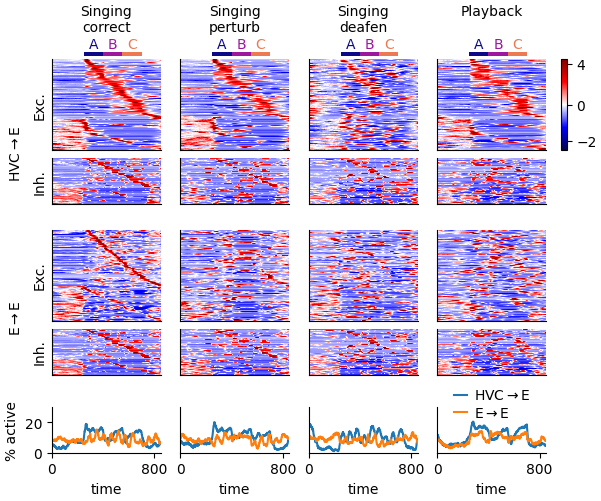

In [130]:
ti, tj = T_burn//2, T_burn + T_rend #int(tsyl_end[2,0])
pop = ('Exc.', 'Inh.', 'Exc.', 'Inh.')
N_tests = len(test_names)
wr = [1]*N_tests+[0.05]
fig, ax = plt.subplots(6, len(wr), 
                       figsize=(6, 5), 
                       width_ratios=wr, 
                       height_ratios=[1, 0.5, 0.1, 1, 0.5, 0.5])
im_idx, ln_idx, white_space_idx = [0, 1, 3, 4], [5], [2]

for i in range(ax.shape[1]):
    for j in white_space_idx:
        ax[j,i].set_axis_off()
ax[-1,-1].set_axis_off()

#### Plot rate heatmaps ####
for i, p in zip(im_idx, pop):
    zs = []
    tests = EI_tests_all if i == 0 else EIrec_tests_all
    for k, l in enumerate(tests['r'+p[0]][:4]):
        zs.append(normalize(l[ti:tj], axis=0))

    zmin = max(min(list(map(lambda _: _[0].min(), zs))), -2.5)
    zmax = min(max(list(map(lambda _: _[0].max(), zs))), 4.5)
    idx = temporal_sort(zs[0], 'dmean', t0=T_burn-ti)[1]

    norm = TwoSlopeNorm(0, -2.5, 4.5)
    
    for k, (z, l) in enumerate(zip(zs, test_names)):
        # Uncomment the below to sort case-by-case
        im = ax[i,k].imshow(z[:,idx].T, aspect='auto', cmap='seismic', 
                            interpolation='none', norm=norm, rasterized=True)
        if i == 0:
            cbar = fig.colorbar(im, cax=ax[i,N_tests])
            # cbar.set_ticks([np.ceil(zmin), 0, np.floor(zmax)-1])
            cbar.set_ticks([-2, 0, 4])
        else:
            ax[i,N_tests].set_axis_off()
        # ax[i,k].axvline(T_burn-ti, ls='--', c='k', lw=2)
        ax[i,k].set(xticks=[], yticks=[])
        ax[0,k].set_title(l+'\n', fontsize=10, va='bottom')
        ax[-1,k].set(xlabel='time', xticks=[0, 800])
    N = zs[0].shape[1]
    ax[i,0].set(ylabel='\n'+p, yticks=[])#, yticks=[N//2, N])
fig.text(0.025, 0.75, 'HVC$\\to$E', rotation=90, ha='center', va='top')
fig.text(0.025, 0.4, 'E$\\to$E', rotation=90, ha='center', va='top')

#### Plot histograms for the heatmaps ####
for i in ln_idx:
    # calculate peak times and active durations
    for rE, c in zip((EI_tests_all['rE'], EIrec_tests_all['rE']), ('C0', 'C1')):
        for k, z in enumerate(rE[:4]):
            peaks = (normalize(z[ti:tj], axis=0) > 1.5).mean(axis=1) * 100
        
            ax[i,k].plot(peaks, color=c, label='HVC$\\to$E' if c == 'C0' else 'E$\\to$E')
            # ax[i,k].axvline(T_burn-ti, ls='--', c='k', lw=2)
            ax[i,k].set(xlim=[0,len(peaks)], yticks=[], ylim=[0, 30])
        ax[i,0].set(yticks=[0, 20], ylabel='% active')
    ax[i,-2].legend(loc=(0.1, 0.6))

#### Plot syl indicators ####
cmap = plt.get_cmap('plasma')
ts = [(tsyl_start[i,0]-ti, tsyl_end[i,0]-ti) for i in range(N_syl)] # for plotting bars
for k in range(4):
    y0, y1 = -20, -N/5
    for i, (t0, t1) in enumerate(ts):
        ax[0,k].add_patch(plt.Rectangle((t0, y0), t1-t0, y1, fc=cmap(i/N_syl), 
                                         clip_on=False, linewidth=0))
        ax[0,k].text((t1+t0)/2, y0+y1, chr(65+i), color=cmap(i/N_syl), ha='center', va='bottom')
fig.savefig('svg/supplementary/compare_EI_EIrec.svg', transparent=True)

## Playback with difference syllable orders

In [26]:
from itertools import product
repeat = 10
shuff_expFF = Experiment(netFF, rH, syl, noise=1, T_test=T_burn+T_rend, 
                         t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
shuff_expEI = Experiment(netEI, rH, syl, noise=1, T_test=T_burn+T_rend, 
                         t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
shuff_expEIrec = Experiment(netEIrec, rH, syl, noise=1, T_test=T_burn+T_rend, 
                            t_start=tsyl_start[:,:1], t_end=tsyl_end[:,:1])
shuff_idxs = [np.array(i) for i in product(range(3), repeat=3) 
              if (i[0] != i[1]) and (i[0] != i[2]) and (i[1] != i[2])]
test_codes = ['shuf_syl_idx'] * len(shuff_idxs) * repeat
if_sing = [False] * len(shuff_idxs) * repeat
FF_tests_shuff = shuff_expFF.sim_multi(test_codes, if_sing, shuff_idx_list=shuff_idxs*repeat)
EI_tests_shuff = shuff_expEI.sim_multi(test_codes, if_sing, shuff_idx_list=shuff_idxs*repeat)
EIrec_tests_shuff = shuff_expEIrec.sim_multi(test_codes, if_sing, shuff_idx_list=shuff_idxs*repeat)

100%|███████████████████████████████████████████| 60/60 [00:13<00:00,  4.51it/s]


In [27]:
# identify those with sequence selectivity
def get_sel_im(tests, n_exp, repeat, im_len):
    mean = np.zeros((n_exp, tests[0].shape[1])) # (n_exp, n_neurons)
    for i in range(n_exp): # avg over time and repetition
        _ = np.stack([_.mean(axis=0) for _ in tests[i::n_exp]], axis=0)
        mean[i,:] = np.mean(_, axis=0)
    cv = mean.std(axis=0) / mean.mean(axis=0) # trial-avg cv
    idx = np.argsort(cv)[::-1]
    im = mean[:,idx[:im_len]]
    im = (im - im.mean()) / im.std()
    return im.T
im_E_FF = get_sel_im(FF_tests_shuff['rE'], len(shuff_idxs), repeat, 30)
im_E_EI = get_sel_im(EI_tests_shuff['rE'], len(shuff_idxs), repeat, 30)
im_I_EI = get_sel_im(EI_tests_shuff['rI'], len(shuff_idxs), repeat, 15)
im_E_EIrec = get_sel_im(EIrec_tests_shuff['rE'], len(shuff_idxs), repeat, 30)
im_I_EIrec = get_sel_im(EIrec_tests_shuff['rI'], len(shuff_idxs), repeat, 15)

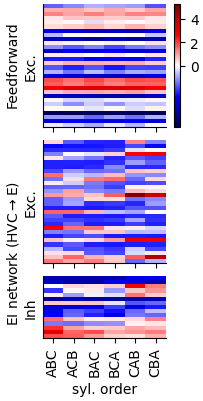

In [28]:
fig, ax = plt.subplots(3, 2, figsize=(2, 4), sharex='col', 
                       width_ratios=[1,0.05], height_ratios=[1,1,0.5])
vmin = min(im_E_EI.min(), im_I_EI.min(), im_E_FF.min())
vmax = max(im_E_EI.max(), im_I_EI.max(), im_E_FF.max())
norm = TwoSlopeNorm(0, vmin, vmax)

for i, im in enumerate((im_E_FF, im_E_EI, im_I_EI)):
    im = ax[i,0].imshow(im, aspect='auto', cmap='seismic', 
                        norm=norm, interpolation='none', rasterized=True)
    ax[i,0].set(xticks=[], yticks=[], ylabel='\nExc.' if i < 2 else '\nInh')
    if i == 0:
        cbar = fig.colorbar(im, cax=ax[0,1])
        # cbar.set_ticks([-1, 0, 2])
    else:
        ax[i,1].set_axis_off()
ax[-1,0].set(xlabel='syl. order')
shuff_chars = [''.join(i) for i in product(('A', 'B', 'C'), repeat=3) 
              if (i[0] != i[1]) and (i[0] != i[2]) and (i[1] != i[2])]
ax[-1,0].set_xticks(np.arange(len(shuff_chars)), 
                    labels=shuff_chars, rotation=90)
fig.text(0.05, 0.95, 'Feedforward', rotation=90, ha='center', va='top')
fig.text(0.05, 0.55, 'EI network (HVC$\\to$E)', rotation=90, ha='center', va='top')
fig.savefig('svg/supplementary/playback_different_order_FF_EI.svg', transparent=True)

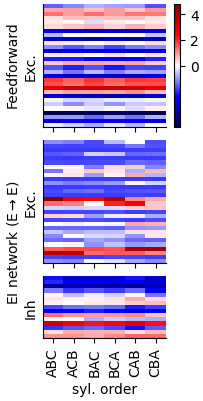

In [29]:
fig, ax = plt.subplots(3, 2, figsize=(2, 4), sharex='col', 
                       width_ratios=[1,0.05], height_ratios=[1,1,0.5])
vmin = min(im_E_EIrec.min(), im_I_EIrec.min(), im_E_FF.min())
vmax = max(im_E_EIrec.max(), im_I_EIrec.max(), im_E_FF.max())
norm = TwoSlopeNorm(0, vmin, vmax)

for i, im in enumerate((im_E_FF, im_E_EIrec, im_I_EIrec)):
    im = ax[i,0].imshow(im, aspect='auto', cmap='seismic', 
                        norm=norm, interpolation='none', rasterized=True)
    ax[i,0].set(xticks=[], yticks=[], ylabel='\nExc.' if i < 2 else '\nInh')
    if i == 0:
        cbar = fig.colorbar(im, cax=ax[0,1])
        # cbar.set_ticks([-1, 0, 2])
    else:
        ax[i,1].set_axis_off()
ax[-1,0].set(xlabel='syl. order')
shuff_chars = [''.join(i) for i in product(('A', 'B', 'C'), repeat=3) 
              if (i[0] != i[1]) and (i[0] != i[2]) and (i[1] != i[2])]
ax[-1,0].set_xticks(np.arange(len(shuff_chars)), 
                    labels=shuff_chars, rotation=90)
fig.text(0.05, 0.95, 'Feedforward', rotation=90, ha='center', va='top')
fig.text(0.05, 0.55, 'EI network (E$\\to$E)', rotation=90, ha='center', va='top')
fig.savefig('svg/supplementary/playback_different_order_FF_EIrec.svg', transparent=True)

In [30]:
# 